# Forecasting NHS staff turnover using Prophet

Data from NHS Digital (Legacy) Workforce Statistics, "Turnover from organisation benchmarking source data, October 2022" https://digital.nhs.uk/data-and-information/publications/statistical/nhs-workforce-statistics/october-2022  
Excel PowerQuery used to wrangle data into usable format.

## Load and explore data

Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from prophet import Prophet

import prophet

#should be version 1.0 according to course but that is not working so trying with latest
prophet.__version__

'1.1.2'

In [3]:
from forecast_tools.model_selection import auto_naive
from forecast_tools.metrics import mean_absolute_error

Load in data (pre-processed), rename some columns and then look at info about loaded data and top 5 rows.

In [5]:
url = '../02_data/2023-01_turnover_annual_csv.csv'
pr_y_train = pd.read_csv(url, parse_dates=['Date'], 
                            dayfirst=True)
                         #,index_col='Date')
pr_y_train.rename(columns={'SIP.FTE':'SIP_FTE','SIP.HC':'SIP_HC'},inplace=True)
pr_y_train['Date'] = pd.to_datetime(pr_y_train['Date'])
#df = df.set_index(['Date', 'Staff group', 'Org code'])
pr_y_train = pr_y_train.sort_values(by='Date')
pr_y_train.info()
#pr_y_train.index.freq = 'D'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303969 entries, 214421 to 296490
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              303969 non-null  datetime64[ns]
 1   Type              303969 non-null  object        
 2   Org code          303969 non-null  object        
 3   Org name          303969 non-null  object        
 4   NHSE region code  303969 non-null  object        
 5   NHSE region name  303969 non-null  object        
 6   ICS code          303969 non-null  object        
 7   ICS name          303969 non-null  object        
 8   Cluster group     303969 non-null  object        
 9   Benchmark group   303969 non-null  object        
 10  Staff group       303969 non-null  object        
 11  HC                303969 non-null  int64         
 12  FTE               303969 non-null  float64       
 13  SIP_HC            296026 non-null  float64       
 14 

In [6]:
pr_y_train.head()

,Date,Type,Org code,Org name,NHSE region code,NHSE region name,ICS code,ICS name,Cluster group,Benchmark group,Staff group,HC,FTE,SIP_HC,SIP_FTE
214421,2018-08-01,Leavers,RRU,London Ambulance Service NHS Trust,Y56,London,QKK,South East London,Ambulance,Ambulance Trust,Senior managers,6,6.00000,66.0,62.82889
156953,2018-08-01,Leavers,RVN,Avon and Wiltshire Mental Health Partnership N...,Y58,South West,QOX,"Bath and North East Somerset, Swindon and Wilt...",Mental Health,Mental Health and Learning Disability,Support to ST&T staff,74,66.95334,224.0,200.60667
207220,2018-08-01,Joiners,RDR,Sussex Community NHS Foundation Trust,Y59,South East,QNX,Sussex,Community Provider Trust,Community Provider Trust,Managers,18,16.70000,78.0,73.12300
278959,2018-08-01,Leavers,RXG,South West Yorkshire Partnership NHS Foundatio...,Y63,North East and Yorkshire,QWO,West Yorkshire,Mental Health,Mental Health and Learning Disability,Other staff or those with unknown classification,2,1.53333,8.0,6.32667
194716,2018-08-01,Leavers,TAF,Camden and Islington NHS Foundation Trust,Y56,London,QMJ,North Central London,Mental Health,Care Trust,Central functions,16,16.00000,103.0,100.32000


The data show the full time equivalent (FTE) and headcount (HC) number of leavers and joiners by organisation and staff group for the previous 12-month period from the date. It also shows the number of staff in post (SIP) HC and FTE averaged over the 12-month period to date.

Drop joiners data to create leavers dataframe. Then drop some staff groups not of interest and drop CCGs and ICBs.

In [7]:
df_leaver = pr_y_train[pr_y_train.Type == 'Leavers']


staff_groups_todrop = ['Other staff or those with unknown classification','Managers','Senior managers','Central functions','Hotel, property & estates']
df_leaver = df_leaver[~df_leaver['Staff group'].isin(staff_groups_todrop)]

trust_types_todrop = ['Clinical Commissioning Group','Integrated Care Board']
df_leaver_trusts = df_leaver[~df_leaver['Cluster group'].isin(trust_types_todrop)]

df_leaver_acute = df_leaver[df_leaver['Cluster group'] == 'Acute']

df_leaver_trusts.head()

df_leaver.head()

,Date,Type,Org code,Org name,NHSE region code,NHSE region name,ICS code,ICS name,Cluster group,Benchmark group,Staff group,HC,FTE,SIP_HC,SIP_FTE
156953,2018-08-01,Leavers,RVN,Avon and Wiltshire Mental Health Partnership N...,Y58,South West,QOX,"Bath and North East Somerset, Swindon and Wilt...",Mental Health,Mental Health and Learning Disability,Support to ST&T staff,74,66.95334,224.0,200.60667
131540,2018-08-01,Leavers,RDU,Frimley Health NHS Foundation Trust,Y59,South East,QNQ,Frimley,Acute,Acute - Large,Midwives,53,41.19665,321.0,265.82398
78433,2018-08-01,Leavers,RX6,North East Ambulance Service NHS Foundation Trust,Y63,North East and Yorkshire,QHM,North East and North Cumbria,Ambulance,Ambulance Trust,Ambulance staff,46,44.46667,781.0,721.62336
67256,2018-08-01,Leavers,RGR,West Suffolk NHS Foundation Trust,Y61,East of England,QJG,Suffolk and North East Essex,Acute,Acute - Small,Nurses & health visitors,95,80.28666,963.0,812.26055
281204,2018-08-01,Leavers,RNA,Dudley Group NHS Foundation Trust,Y60,Midlands,QUA,Black Country,Acute,Acute - Medium,Ambulance staff,2,2.00000,7.0,7.00000


Dataframe of one org for testing

In [8]:
org = 'RAE'

df_org = df_leaver[df_leaver['Org code']==org]

df_org = df_org.groupby(['Date','Staff group']).agg({'FTE':'sum','SIP_FTE':'sum','HC':'sum','SIP_HC':'sum'})
df_org['rate'] = df_org['FTE']/df_org['SIP_FTE']
#df_org

Graph of "all staff" leaver rate in the one testing org over time.

In [9]:
#_ = sg_df['rate'].plot(figsize=(15,6))
#df_org.unstack(level=1)['rate']['All staff groups'].plot(figsize=(15,6))

# set the x-axis and y-axis labels
#plt.xlabel('Date')
#plt.ylabel('Rate')
#plt.legend(title='Staff Group')

# display the plot
#plt.show()

Create a new dataframe where dependent variables are aggregated up by date and staff group and add a "rate" column

In [10]:
df_leaver_trusts_sg = df_leaver_trusts.groupby(['Date','Staff group']).agg({'FTE':'sum','SIP_FTE':'sum','HC':'sum','SIP_HC':'sum'})
df_leaver_trusts_sg['rate'] = df_leaver_trusts_sg['FTE']/df_leaver_trusts_sg['SIP_FTE']


#sg_df.set_index('Date')
df_leaver_trusts_sg.head()
#_ = leaver_df.groupby('Staff group')['FTE'].plot(figsize=(12,4),legend=True)

FTE       SIP_FTE      HC  \
Date       Staff group                                                          
2018-08-01 All staff groups                110213.97166  927324.17196  128264   
           Ambulance staff                   1657.61243   20728.32207    1811   
           HCHS doctors (exc. junior Drs)    4295.47627   51888.83114    5187   
           Midwives                          1958.46419   19676.74468    2407   
           Nurses & health visitors         32185.21460  260814.13418   36724   

                                              SIP_HC      rate  
Date       Staff group                                          
2018-08-01 All staff groups                1059193.0  0.118852  
           Ambulance staff                   22040.0  0.079968  
           HCHS doctors (exc. junior Drs)    57186.0  0.082782  
           Midwives                          23860.0  0.099532  
           Nurses & health visitors         293273.0  0.123403

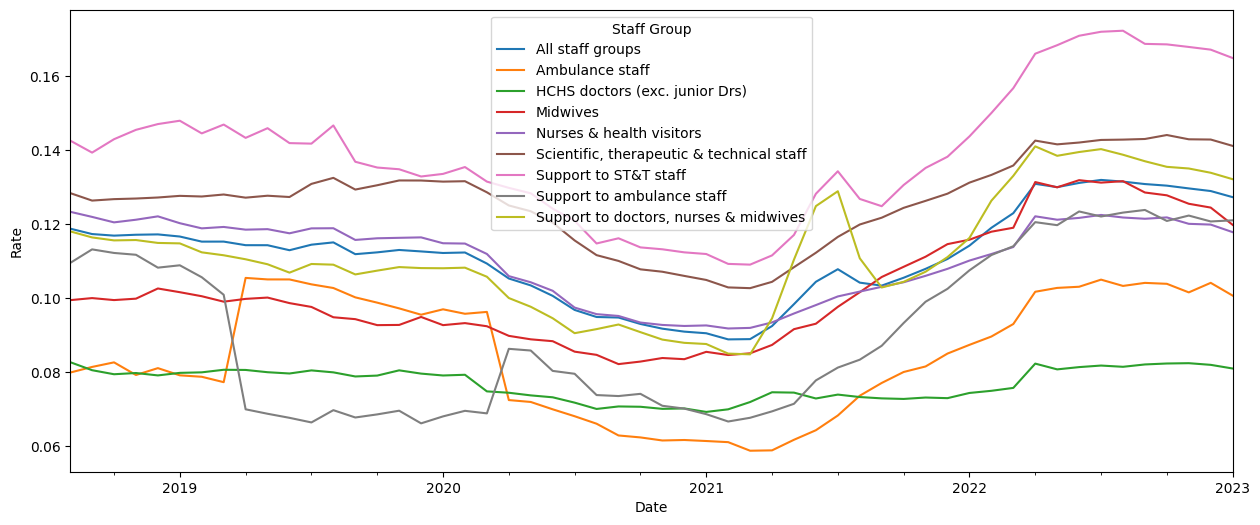

In [11]:
#_ = sg_df['rate'].plot(figsize=(15,6))
df_leaver_trusts_sg.unstack(level=1)['rate'].plot(figsize=(15,6))

# set the x-axis and y-axis labels
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend(title='Staff Group')

# display the plot
plt.show()

Did the coding of Ambulance staff and Support to ambulance staff change at some point, explaining the strange patterns in turnover Mar-2019 to Mar-2020?

In [12]:
#_ = sg_df['rate'].plot(figsize=(15,6))

staff_groups_toplot = ['All staff groups','Midwives','Nurses & health visitors']
df_leaver_sg_toplot = df_leaver[df_leaver['Staff group'].isin(staff_groups_toplot)]

df_leaver_sg_toplot = df_leaver_sg_toplot.groupby(['Date','Staff group']).agg({'FTE':'sum','SIP_FTE':'sum','HC':'sum','SIP_HC':'sum'})
df_leaver_sg_toplot['rate'] = df_leaver_sg_toplot['FTE']/df_leaver_sg_toplot['SIP_FTE']

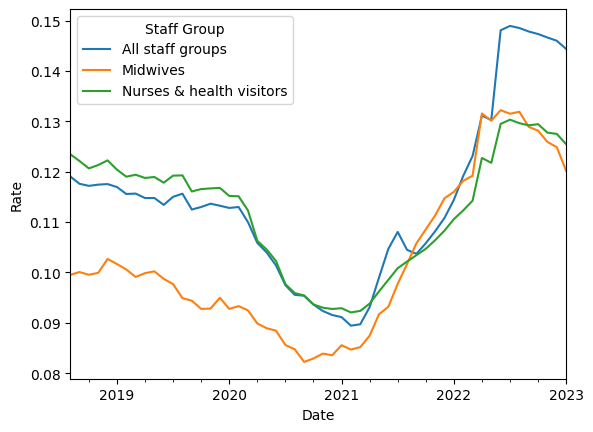

In [13]:
df_leaver_sg_toplot.unstack(level=1)['rate'].plot.line()

# set the x-axis and y-axis labels
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend(title='Staff Group')

# display the plot
plt.show()

## Put data into format suitable for Prophet forecasting

Take the rate column from the dataframe plotted above and specify one staff group. y\_train contains national level leaver rates by month for specified staff group then convert to dataframe.

In [14]:
staff_group = 'Nurses & health visitors'

y_train = df_leaver_trusts_sg.unstack(level=1)['rate'][staff_group]
y_train.head()

Date
2018-08-01    0.123403
2018-09-01    0.122021
2018-10-01    0.120544
2018-11-01    0.121258
2018-12-01    0.122170
Name: Nurses & health visitors, dtype: float64

In [15]:
#y_train.set_index('Date')
y_train = y_train.to_frame()
#y_train['turnover rate'] = y_train['All staff groups']
y_train.head()

,Nurses & health visitors
Date,
2018-08-01,0.123403
2018-09-01,0.122021
2018-10-01,0.120544
2018-11-01,0.121258
2018-12-01,0.122170


The below function converts the training data into the correct format for Prophet giving a dataframe with 2 columns: 'ds': the date; 'y': the leaver rate.

In [16]:
def prophet_training_data(y_train):
    '''
    Converts a standard pandas datetimeindexed dataframe
    for time series into one suitable for Prophet
    Parameters:
    ---------
    y_train: pd.DataFrame
        univariate time series data
        
    Returns:
    --------
        pd.DataFrame in Prophet format 
        columns = ['ds', 'y']
    '''
    prophet_train = pd.DataFrame(y_train.index)
    prophet_train['y'] = y_train.to_numpy()
    prophet_train.columns = ['ds', 'y']

    return prophet_train

Apply function to our data

In [17]:
yp_train = prophet_training_data(y_train)

In [18]:
yp_train.tail()

,ds,y
49,2022-09-01,0.121517
50,2022-10-01,0.121881
51,2022-11-01,0.120151
52,2022-12-01,0.119943
53,2023-01-01,0.117902


## Fit and predict data with Prophet

Create the first Prophet object called 'model', with a 95% interval width. Apply to our data.

In [19]:
#model = Prophet(interval_width=0.95,
#               seasonality_mode='multiplicative')

model = Prophet(interval_width=0.95)
model.fit(yp_train)

14:08:51 - cmdstanpy - INFO - Chain [1] start processing


14:08:52 - cmdstanpy - INFO - Chain [1] done processing


Specify monthly data here in the frequency (freq='MS')

In [20]:
future = model.make_future_dataframe(periods=24, freq='MS')
future.tail()

,ds
73,2024-09-01
74,2024-10-01
75,2024-11-01
76,2024-12-01
77,2025-01-01


In [21]:
prophet_forecast = model.predict(future)
prophet_forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
73,2024-09-01,0.157590,0.141230,0.171740,0.143244,0.170308,-0.000509,-0.000509,-0.000509,-0.000509,-0.000509,-0.000509,0.0,0.0,0.0,0.157080
74,2024-10-01,0.159056,0.141709,0.171898,0.143901,0.172943,-0.001494,-0.001494,-0.001494,-0.001494,-0.001494,-0.001494,0.0,0.0,0.0,0.157562
75,2024-11-01,0.160572,0.141748,0.175585,0.144680,0.175322,-0.001810,-0.001810,-0.001810,-0.001810,-0.001810,-0.001810,0.0,0.0,0.0,0.158762
76,2024-12-01,0.162038,0.142179,0.177290,0.145126,0.177734,-0.001984,-0.001984,-0.001984,-0.001984,-0.001984,-0.001984,0.0,0.0,0.0,0.160054
77,2025-01-01,0.163554,0.143520,0.179029,0.145503,0.180435,-0.001779,-0.001779,-0.001779,-0.001779,-0.001779,-0.001779,0.0,0.0,0.0,0.161775


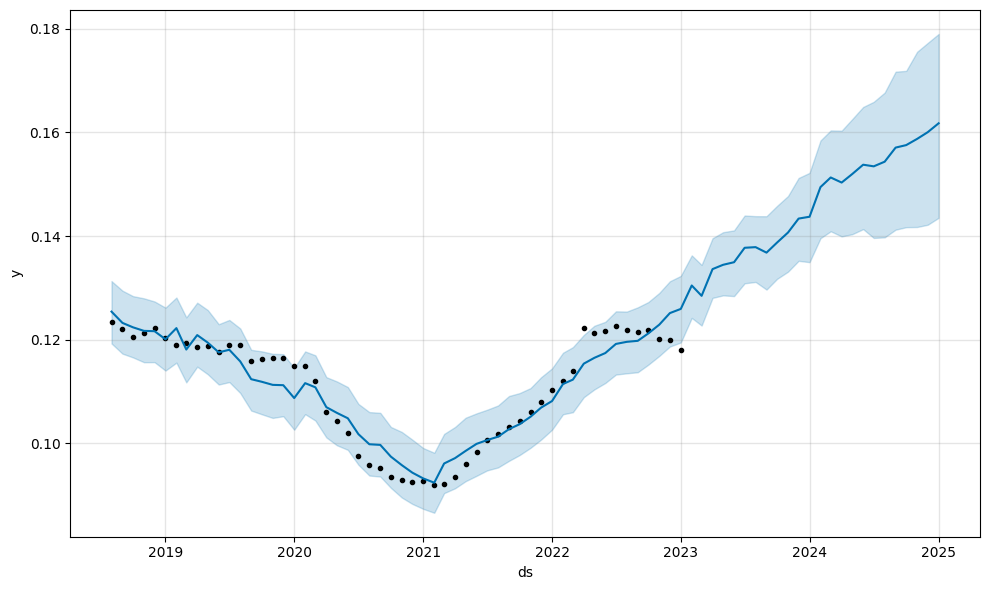

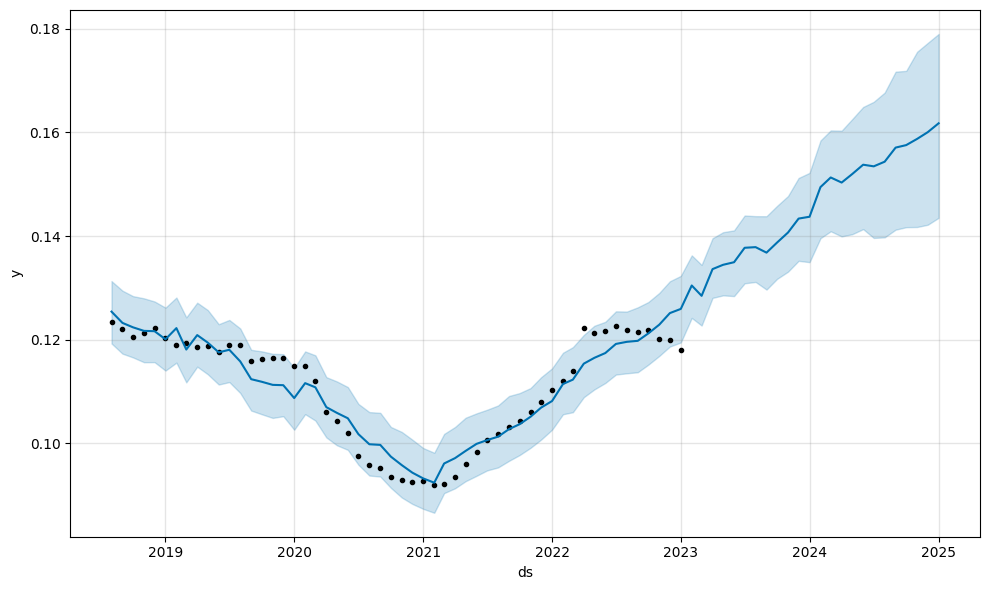

In [22]:
model.plot(prophet_forecast)

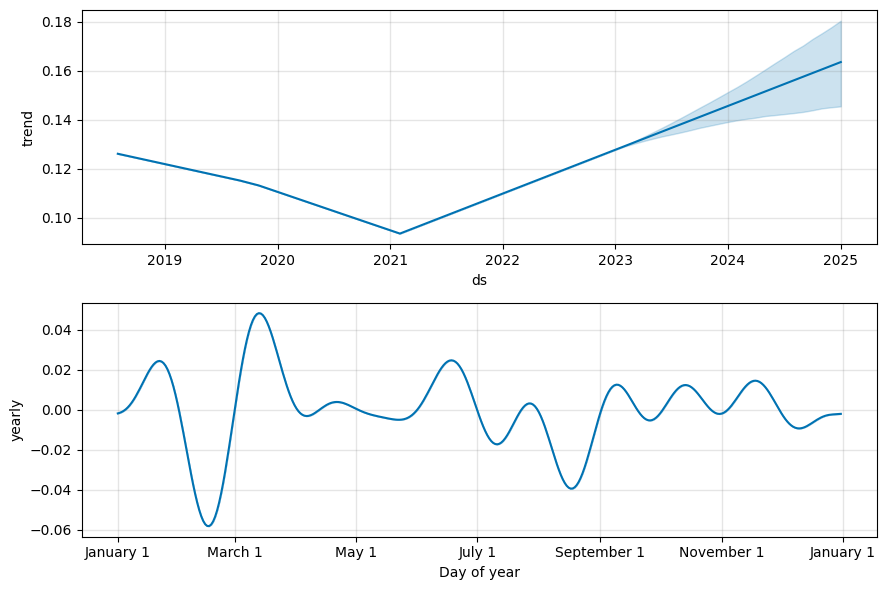

In [23]:
_ = model.plot_components(prophet_forecast)

## Adding changepoints to Prophet

Changepoints are the datetime points where the time series have abrupt changes in the trajectory.

Let’s plot the vertical lines where the potential changepoints occurred

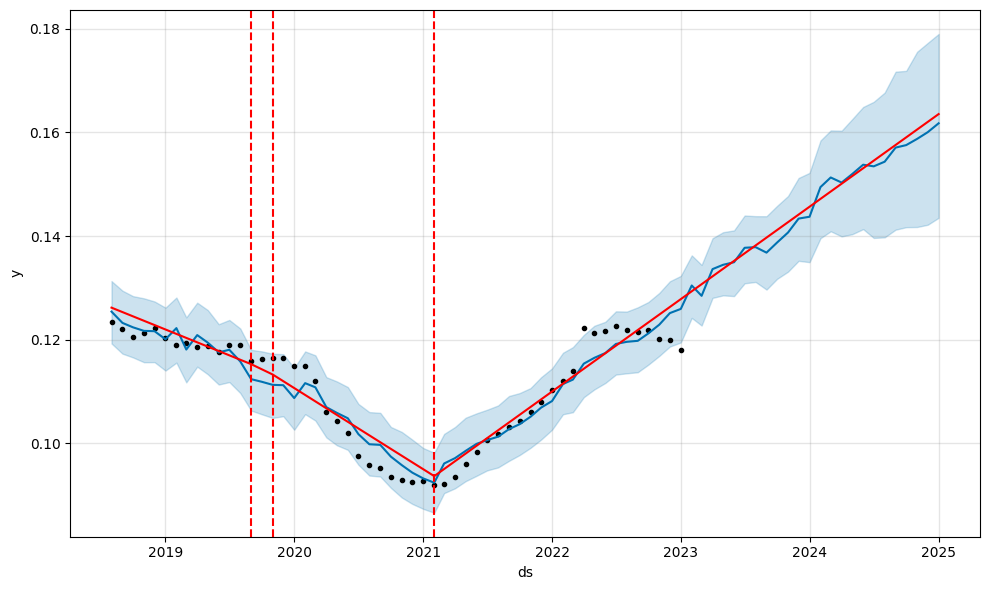

In [24]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(prophet_forecast)
a = add_changepoints_to_plot(fig.gca(), model, prophet_forecast)

We can change the inferred changepoint range by setting the changepoint\_range, the number of changepoints with n\_changepoints, and changepoint\_prior\_scale to adjust the trend. 

Default value for changepoint\_prior\_scale is 0.05. Decrease the value to make the trend less flexible. Increase the value of changepoint\_prior\_scale to make the trend more flexible.

14:09:38 - cmdstanpy - INFO - Chain [1] start processing


14:09:39 - cmdstanpy - INFO - Chain [1] done processing


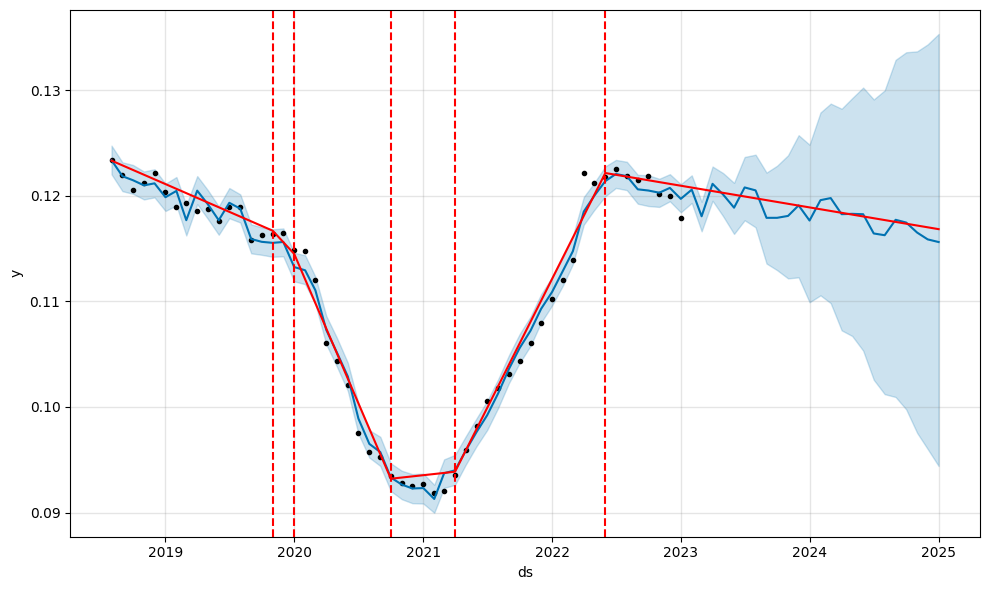

In [25]:
#pro_change = Prophet(changepoint_range=0.9)

model_1 = Prophet(n_changepoints = 45, changepoint_range=0.9, changepoint_prior_scale=0.05, yearly_seasonality = True)


prophet_forecast_1 = model_1.fit(yp_train).predict(future)
fig= model_1.plot(prophet_forecast_1)
a = add_changepoints_to_plot(fig.gca(), model_1, prophet_forecast_1)


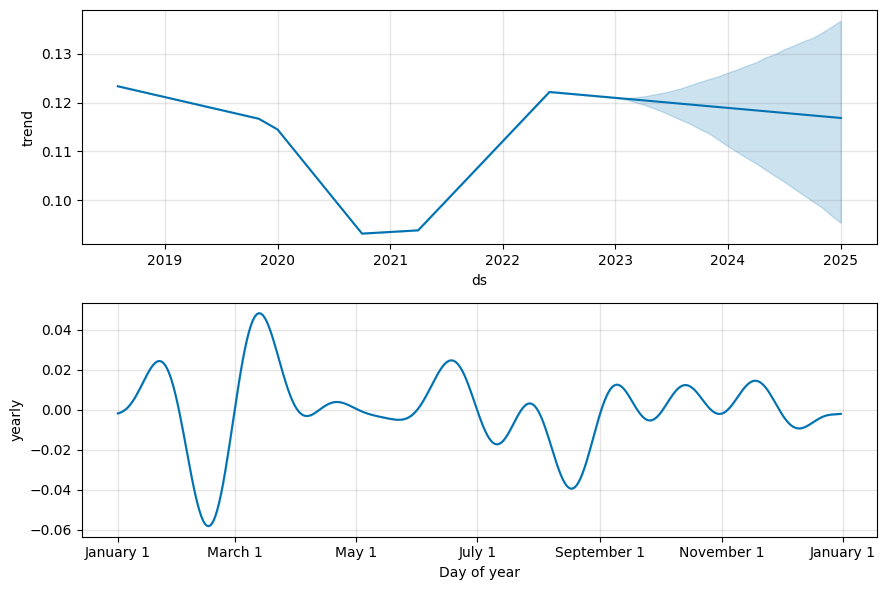

In [26]:
_ = model.plot_components(prophet_forecast_1)

## Adding a COVID-related regressor

[https://towardsdatascience.com/using-prophet-after-covid-read-this-first-fc27cd77f3d7](https://towardsdatascience.com/using-prophet-after-covid-read-this-first-fc27cd77f3d7)

The pandemic clearly had a big impact on our primary variable. Between March 2020 and March 2021, turnover rates plummeted as NHS staff were more likely to stay in their role to support the pandemic and there was less possibility for change in employment. From April 2021 onwards, turnover rate rapidly increased again to pre-COVID levels and then beyond. There is some indication that rates are stabilising in recent months, but it is unclear whether rates will drop, plateau or continue to rise (hence forecasting!).

In the previous section you can see that the model interprets the data trend in different ways depending on the model parameters. Initially, the model only picks up on the downward trend pre-April 2021 and the upward trend post-April 2021. Therefore it forecasts an ever increasing rate. When the number of changepoints is in increased, it picks up on the downward trend pre-March 2020, the steeper downward trend Mar-2020 to Apr-2021 and the hints of a plateau in the most recent months. 

Forecasting with this data is very challenging because so much of the time series is affected by COVID, as it only goes back to 2018.

Additional regressors can be added to the Prophet model by using add\_regressor. Additional regressor column value needs to be present in both the fitting as well as prediction dataframes.

I want to add Google mobility data as a COVID-proxy regressor. We assume that staff members were less mobile in the NHS and wider workforce during COVID, leading to lower turnover rates, therefore this is a highly suitable measure of the impact of COVID on turnover. 

I downloaded "Global CSV" from the link below and saved it in my data folder. I specify which columns to load in as some are not needed.  
[https://www.google.com/covid19/mobility/](https://www.google.com/covid19/mobility/)

In [35]:
url = '../02_data/Global_Mobility_Report.csv'
df_gmr = pd.read_csv(url, usecols=['country_region_code','date',
                    'retail_and_recreation_percent_change_from_baseline',
                    'grocery_and_pharmacy_percent_change_from_baseline',
                    'parks_percent_change_from_baseline',
                    'transit_stations_percent_change_from_baseline',
                    'workplaces_percent_change_from_baseline',
                    'residential_percent_change_from_baseline'])
                         #,index_col='Date')


In [36]:
df_gmr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11730025 entries, 0 to 11730024
Data columns (total 8 columns):
 #   Column                                              Dtype  
---  ------                                              -----  
 0   country_region_code                                 object 
 1   date                                                object 
 2   retail_and_recreation_percent_change_from_baseline  float64
 3   grocery_and_pharmacy_percent_change_from_baseline   float64
 4   parks_percent_change_from_baseline                  float64
 5   transit_stations_percent_change_from_baseline       float64
 6   workplaces_percent_change_from_baseline             float64
 7   residential_percent_change_from_baseline            float64
dtypes: float64(6), object(2)
memory usage: 715.9+ MB


I drop all other countries except for UK (coded as GB in the dataset). Then rename some of the columns to be shorter. The values refer to percent change from baseline where baseline is a normal value for that day of the week. The baseline day is the median value from the five‑week period 3 Jan – 6 Feb 2020.

In [39]:

df_gmr = df_gmr[df_gmr.country_region_code == 'GB']


df_gmr.rename(columns={'retail_and_recreation_percent_change_from_baseline':'retail_and_rec',
                    'grocery_and_pharmacy_percent_change_from_baseline':'grocery_and_pharm',
                    'parks_percent_change_from_baseline':'parks',
                    'transit_stations_percent_change_from_baseline':'transit',
                    'workplaces_percent_change_from_baseline':'workplaces',
                    'residential_percent_change_from_baseline':'residential'},
                    inplace=True)

df_gmr['date'] = pd.to_datetime(df_gmr['date'])
df_gmr = df_gmr.set_index('date')

df_gmr.head()

D:\TEMP\ipykernel_2868\2857716944.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gmr.rename(columns={'retail_and_recreation_percent_change_from_baseline':'retail_and_rec',
D:\TEMP\ipykernel_2868\2857716944.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gmr['date'] = pd.to_datetime(df_gmr['date'])


,country_region_code,retail_and_rec,grocery_and_pharm,parks,transit,workplaces,residential
date,,,,,,,
2020-02-15,GB,-12.0,-7.0,-35.0,-12.0,-4.0,2.0
2020-02-16,GB,-7.0,-6.0,-28.0,-7.0,-3.0,1.0
2020-02-17,GB,10.0,1.0,24.0,-2.0,-14.0,2.0
2020-02-18,GB,7.0,-1.0,20.0,-3.0,-14.0,2.0
2020-02-19,GB,6.0,-2.0,8.0,-4.0,-14.0,3.0


In [40]:
df_gmr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 406271 entries, 2020-02-15 to 2022-10-15
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   country_region_code  406271 non-null  object 
 1   retail_and_rec       395937 non-null  float64
 2   grocery_and_pharm    395856 non-null  float64
 3   parks                320171 non-null  float64
 4   transit              393872 non-null  float64
 5   workplaces           404430 non-null  float64
 6   residential          385135 non-null  float64
dtypes: float64(6), object(1)
memory usage: 24.8+ MB


The google mobility data is daily whereas my dependent variable data (turnover) is monthly.  We need to aggregate the daily data.

Resample the daily data to monthly using the mean function, then join the monthly regressor data with the main DataFrame:

In [41]:
df_gmr_monthly = df_gmr.resample('MS').mean()
df_gmr_monthly.head()

D:\TEMP\ipykernel_2868\3536794977.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_gmr_monthly = df_gmr.resample('MS').mean()


,retail_and_rec,grocery_and_pharm,parks,transit,workplaces,residential
date,,,,,,
2020-02-01,0.864475,-0.113017,-4.014356,-1.930967,-5.630956,1.460651
2020-03-01,-26.054090,-2.178818,0.906844,-24.910201,-22.353614,8.768827
2020-04-01,-74.729972,-32.203622,-14.089916,-62.689852,-64.034794,25.596975
2020-05-01,-66.811534,-20.942173,30.798903,-49.052734,-54.160031,21.262237
2020-06-01,-53.246371,-12.906225,42.303393,-40.174753,-42.083167,16.958969


I will start with mobility data about "workplaces" as my first regressor - I need to attach it to my dependent variable data. I have a new dataframe with one additional regressor (df\_r1)

In [59]:
df_r1 = pd.concat([y_train,df_gmr_monthly.workplaces], axis=1)
#df_r1

In [60]:
#test_p = prophet_training_data(test)
df_r1 = df_r1.rename(columns={staff_group: 'y'})
df_r1['ds'] = df_r1.index
df_r1 = df_r1[['ds','y','workplaces']]
df_r1['workplaces'] = df_r1['workplaces'].fillna(0)
df_r1.tail()


,ds,y,workplaces
2022-09-01,2022-09-01,0.121517,-22.249641
2022-10-01,2022-10-01,0.121881,-17.810353
2022-11-01,2022-11-01,0.120151,0.000000
2022-12-01,2022-12-01,0.119943,0.000000
2023-01-01,2023-01-01,0.117902,0.000000


We need to create a new model object (previous was called "model\_1", so now model\_2). I will give the same model settings as the previous (which picked up on more complex changes in the existing time series). We tell the model object what the names of the regressor fields are.

In [64]:
model_2 = Prophet(n_changepoints = 45,changepoint_range=0.9, 
                changepoint_prior_scale=0.05,yearly_seasonality=True)
model_2.add_regressor('workplaces')

In [66]:
model_2.fit(df_r1)

14:51:19 - cmdstanpy - INFO - Chain [1] start processing


14:51:19 - cmdstanpy - INFO - Chain [1] done processing


Add the additional regressor to the future time series (0 where outside of the time range).

In [67]:
future = model_2.make_future_dataframe(periods=24, freq='MS')
future['workplaces'] = df_r1['workplaces']
future['workplaces'] = future['workplaces'].fillna(0)

future.tail()

,ds,workplaces
73,2024-09-01,0.0
74,2024-10-01,0.0
75,2024-11-01,0.0
76,2024-12-01,0.0
77,2025-01-01,0.0


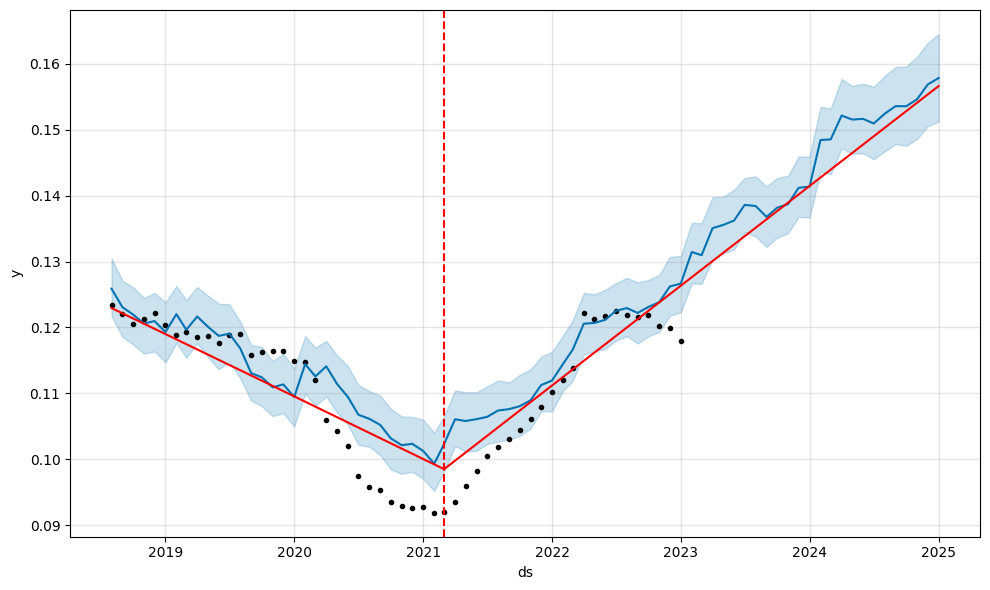

In [68]:
prophet_forecast_2 = model_2.predict(future)

fig2 = model_2.plot(prophet_forecast_2)
a = add_changepoints_to_plot(fig2.gca(), model_2, prophet_forecast_2)


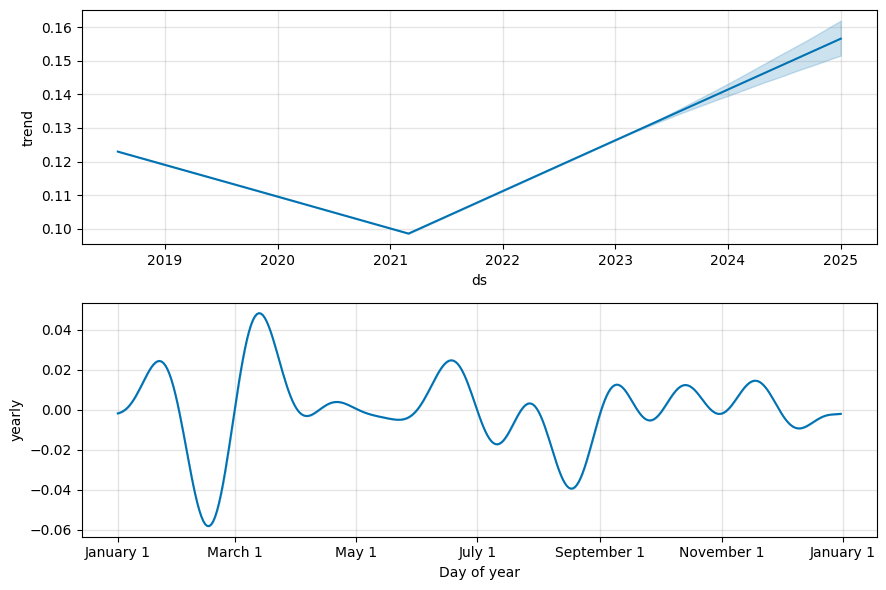

In [69]:
_ = model.plot_components(prophet_forecast_2)

Now adding all GMR variables as regressors. First add to dataframe and save as df\_r\_gmr.

In [70]:
df_r_gmr = y_train.join(df_gmr_monthly[['retail_and_rec',
	'grocery_and_pharm','parks','transit',
    'workplaces','residential']])
df_r_gmr = df_r_gmr.rename(columns={'Nurses & health visitors': 'y'})
df_r_gmr['ds'] = df_r_gmr.index
df_r_gmr = df_r_gmr[['ds','y','retail_and_rec',
	'grocery_and_pharm','parks','transit',
    'workplaces','residential']]
df_r_gmr = df_r_gmr[['ds','y','retail_and_rec',
	'grocery_and_pharm','parks','transit',
    'workplaces','residential']].fillna(0)
df_r_gmr.tail()

,ds,y,retail_and_rec,grocery_and_pharm,parks,transit,workplaces,residential
Date,,,,,,,,
2022-09-01,2022-09-01,0.121517,-4.881844,9.51915,39.452341,-16.572371,-22.249641,3.833238
2022-10-01,2022-10-01,0.121881,-4.326333,10.50300,27.856538,-19.945277,-17.810353,3.464590
2022-11-01,2022-11-01,0.120151,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2022-12-01,2022-12-01,0.119943,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2023-01-01,2023-01-01,0.117902,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


Create a new model object and add all regressors.

In [111]:
model_gmr = Prophet(n_changepoints = 55, changepoint_range=0.85, changepoint_prior_scale=0.07
                )
#            , yearly_seasonality = True)

model_gmr.add_regressor('retail_and_rec')
model_gmr.add_regressor('grocery_and_pharm')
model_gmr.add_regressor('parks')
model_gmr.add_regressor('transit')
model_gmr.add_regressor('workplaces')
model_gmr.add_regressor('residential')


In [112]:
model_gmr.fit(df_r_gmr)

15:12:34 - cmdstanpy - INFO - Chain [1] start processing


15:12:35 - cmdstanpy - INFO - Chain [1] done processing


In [113]:
future = model_gmr.make_future_dataframe(periods=24, freq='MS')

future[['retail_and_rec',
	'grocery_and_pharm','parks','transit',
    'workplaces','residential']]  = df_r_gmr[['retail_and_rec',
	'grocery_and_pharm','parks','transit',
    'workplaces','residential']]
future[['retail_and_rec',
	'grocery_and_pharm','parks','transit',
    'workplaces','residential']]  = future[['retail_and_rec',
	'grocery_and_pharm','parks','transit',
    'workplaces','residential']].fillna(0)

#future.tail()

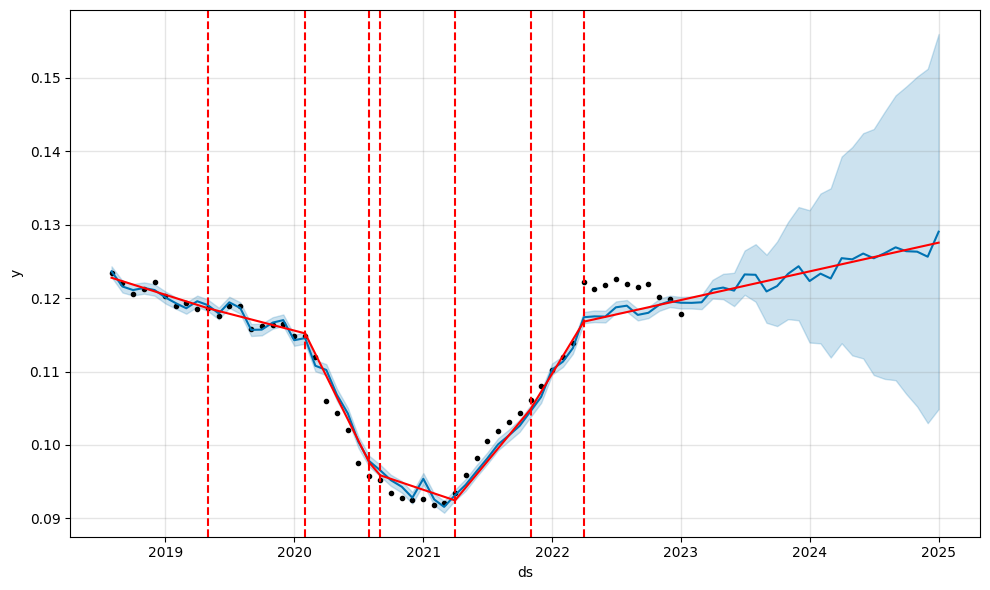

In [114]:
prophet_forecast_gmr = model_gmr.predict(future)

fig3 = model_gmr.plot(prophet_forecast_gmr)
a = add_changepoints_to_plot(fig3.gca(), model_gmr, prophet_forecast_gmr)

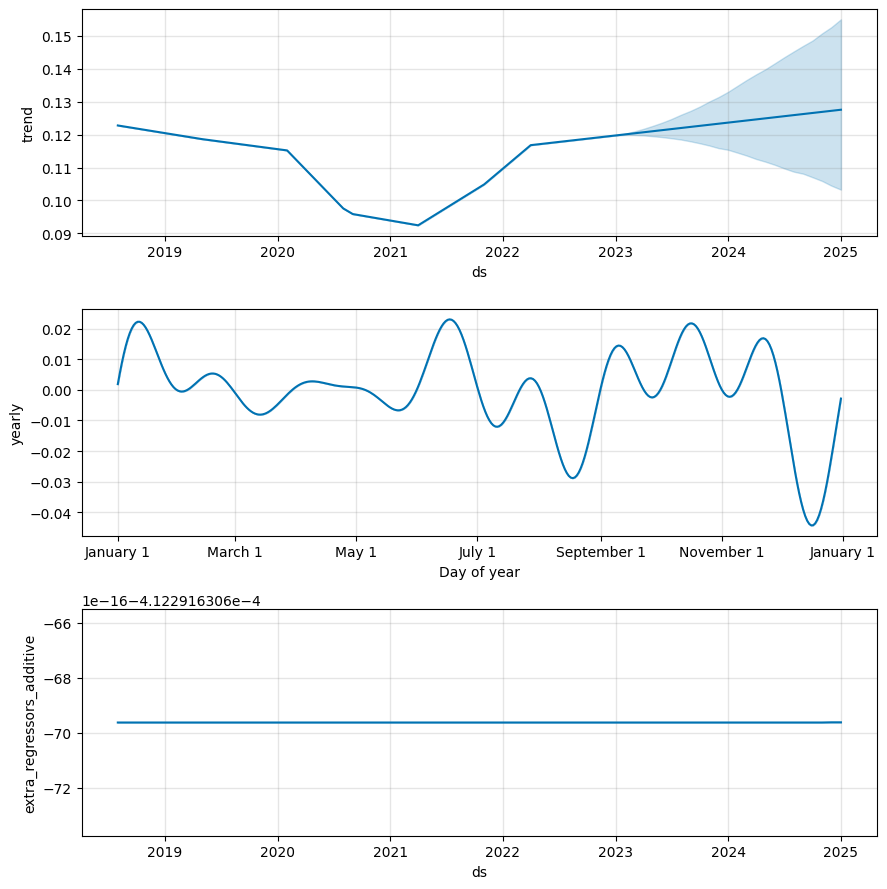

In [115]:
_ = model_gmr.plot_components(prophet_forecast_gmr)

## Adding other regressors

[https://towardsdatascience.com/time-series-prediction-using-prophet-in-python-35d65f626236](https://towardsdatascience.com/time-series-prediction-using-prophet-in-python-35d65f626236)

## Evaluating model fit

Take from prophet\_exercises\_SOLUTIONS